# Sandbox

Sandbox script to work on functions while other functions are running in the background

In [1]:
%reset -f

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload
%autoreload 2

In [128]:
import sys

sys.path.append('/home/hbyrne/Research/Tools')

In [136]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, ClassifyModels, CreateScenarioDictionary, ClassifyHistModelsLite, ConcatModels, CreateScenarioDictionaryLite
from GradientProjectFunctions import ExtendPeriod
from Utils_Functions_HB import SelectModelInputs

### Working on matching up historical and scenario models when there isn't a one:one

In [41]:
# inputting from a csv file
directory = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

# inputting the historical data
fileName = 'cmip6_historical_opendap.csv'
os.chdir(directory)
inputHist = pd.read_csv(fileName)

# inputting the scenario data
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputScenario = pd.read_csv(fileName)

# selecting the models
#models = ['MIROC6', 'CanESM5', 'GISS-E2-1-G', 'IPSL-CM6A-LR']
models = ['EC-Earth3']

# filtering for the subset of links we are interested in
# first filtering the Scenario datasets because these are more limited
scenarioFilt = inputScenario[(inputScenario['experiment_id'] == 'ssp245') &
                             (inputScenario['variable_id'] == 'ts') &
                             ((inputScenario['grid_label'] == 'gn') |
                             (inputScenario['grid_label'] == 'gr'))
                            ]

# filtering the historical datasets based on which also have scenarios
histFilt = inputHist[inputHist['source_id'].isin(models) &
                     (inputHist['variable_id'] == 'ts') & 
                     ((inputHist['grid_label'] == 'gn') |
                     (inputHist['grid_label'] == 'gr'))
                    ]

# then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

# saving all of the urls into one list
modelListHist = histFilt['URL'].tolist()
modelListScenario = scenarioFilt['URL'].tolist()

In [6]:
histModelsTest = ClassifyHistModelsLite(modelListHist)

## Script that calculates the jump and combines it with information about whether this was random or non-random

### Assignment information for all models that were run together

In [488]:
matchDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Model_Statistics'
os.chdir(matchDir)

fileName = 'Match_data22024-03-14.csv'
matchData = pd.read_csv(fileName, index_col = 0)

# creating a new column with the model name (note that these are all before the first _)
models = []
for modelName in list(matchData.index):
    charIndex = modelName.index('_')
    models.append(modelName[:charIndex])
    
matchData['Model'] = models
matchData.reindex(columns = ['Model', 'ScenModel', 'Assignment']);

In [491]:
matchData.Model.unique()

array(['CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'GISS-E2-1-G'], dtype=object)

In [504]:
# from the concat jump function

# want to add in a function to also have it be compared to Dec / Jan jumps for the rest of the period
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients2_2024-03-14'
os.chdir(gradientsDir)

# list of models that we are interested in for this
models = ['CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'GISS-E2-1-G']

# list for holding model names
modelNamesGrad = []

# lists for holding the concat information
concatJumpFullHist = []
concatJumpJanDec = []

for modelName in models:
    
    # get a list of all of the files in the directory (getting rid of the python checkpoints one)
    gradientFiles = os.listdir(gradientsDir)
    gradientFiles = [f for f in gradientFiles if '.nc' in f and modelName in f]

    histStart = '1850-01-16T12:00:00.000000000'
    histEnd = '2014-12-16T12:00:00.000000000'
    scenStart = '2015-01-16T12:00:00.000000000'

    for file in gradientFiles:      
        # getting the modelName
        charIndex = file.index('.')
        modelNamesGrad.append(file[:charIndex])

        # calculating the jump relative to std
        modelGradient = xr.open_dataset(file)
        jump = (modelGradient.sel(time = histEnd) - modelGradient.sel(time = scenStart)).ts.item()

        # calculating standard deviation of historical period
        stdHist = modelGradient.sel(time = slice(histStart, histEnd)).std(dim = 'time').ts.item()
        meanHist = modelGradient.sel(time = slice(histStart, histEnd)).mean(dim = 'time').ts.item()

        concatJumpFullHist.append((jump - meanHist)/stdHist)

        # calculating difference between December and January for historical period
        # first selecting the right period so that we have Jan of 1851 and December of 1850 at the start and Jan 2015 and Dec 2014 at the end
        janStart = '1851-01-16T12:00:00.000000000'
        janEnd = '2015-02-16T12:00:00.000000000'
        decStart = '1850-01-16T12:00:00.000000000'
        decEnd = '2015-01-16T12:00:00.000000000'

        janValues = modelGradient.sel(time = slice(janStart, janEnd)).where(modelGradient['month'] == 1, drop = True).ts.values
        decValues = modelGradient.sel(time = slice(decStart, decEnd)).where(modelGradient['month'] == 12, drop = True).ts.values
        janDecDiff = janValues - decValues
        janDecDiffMean = np.mean(janDecDiff)
        janDecDiffSTD = np.std(janDecDiff)

        concatJumpJanDec.append((jump - janDecDiffMean)/janDecDiffSTD)
        
# adding in the jump information for all of the models
# first get a list of jump information corresponding to the histModel indices
jumpMatchHist = np.zeros(len(matchData.index))
jumpMatchJanDec = np.zeros(len(matchData.index))

for i, histModelMatch in enumerate(matchData.index):
    if histModelMatch in modelNamesGrad:
        jumpMatchHist[i] = concatJumpFullHist[modelNamesGrad.index(histModelMatch)]
        jumpMatchJanDec[i] = concatJumpJanDec[modelNamesGrad.index(histModelMatch)]
    else:
        jumpMatchHist[i] = np.nan
        jumpMatchJanDec[i] = np.nan

# now append this to the matchData frame
matchData['ConcatJumpHist'] = jumpMatchHist
matchData['ConcatJumpJanDec'] = jumpMatchJanDec

# adding in a column of colours based on assigment
colours = []

for assignment in matchData.Assignment:
    if assignment == 'Random':
        colours.append('Red')
    else:
        colours.append('Blue')

matchData['Colour_Assignment'] = colours

In [505]:
matchData.head()

,ScenModel,Assignment,Model,ConcatJumpHist,ConcatJumpJanDec,Colour_Assignment
HistModel,,,,,,
CanESM5_r10i1p1f1,CanESM5_r10i1p1f1,Non-random,CanESM5,-0.141881,-0.213373,Blue
CanESM5_r10i1p2f1,CanESM5_r10i1p2f1,Non-random,CanESM5,-0.412738,-0.541625,Blue
CanESM5_r11i1p1f1,CanESM5_r11i1p1f1,Non-random,CanESM5,0.589678,1.009405,Blue
CanESM5_r11i1p2f1,CanESM5_r11i1p2f1,Non-random,CanESM5,0.053043,0.146496,Blue
CanESM5_r12i1p1f1,CanESM5_r12i1p1f1,Non-random,CanESM5,-0.854921,-1.413244,Blue


## Plotting

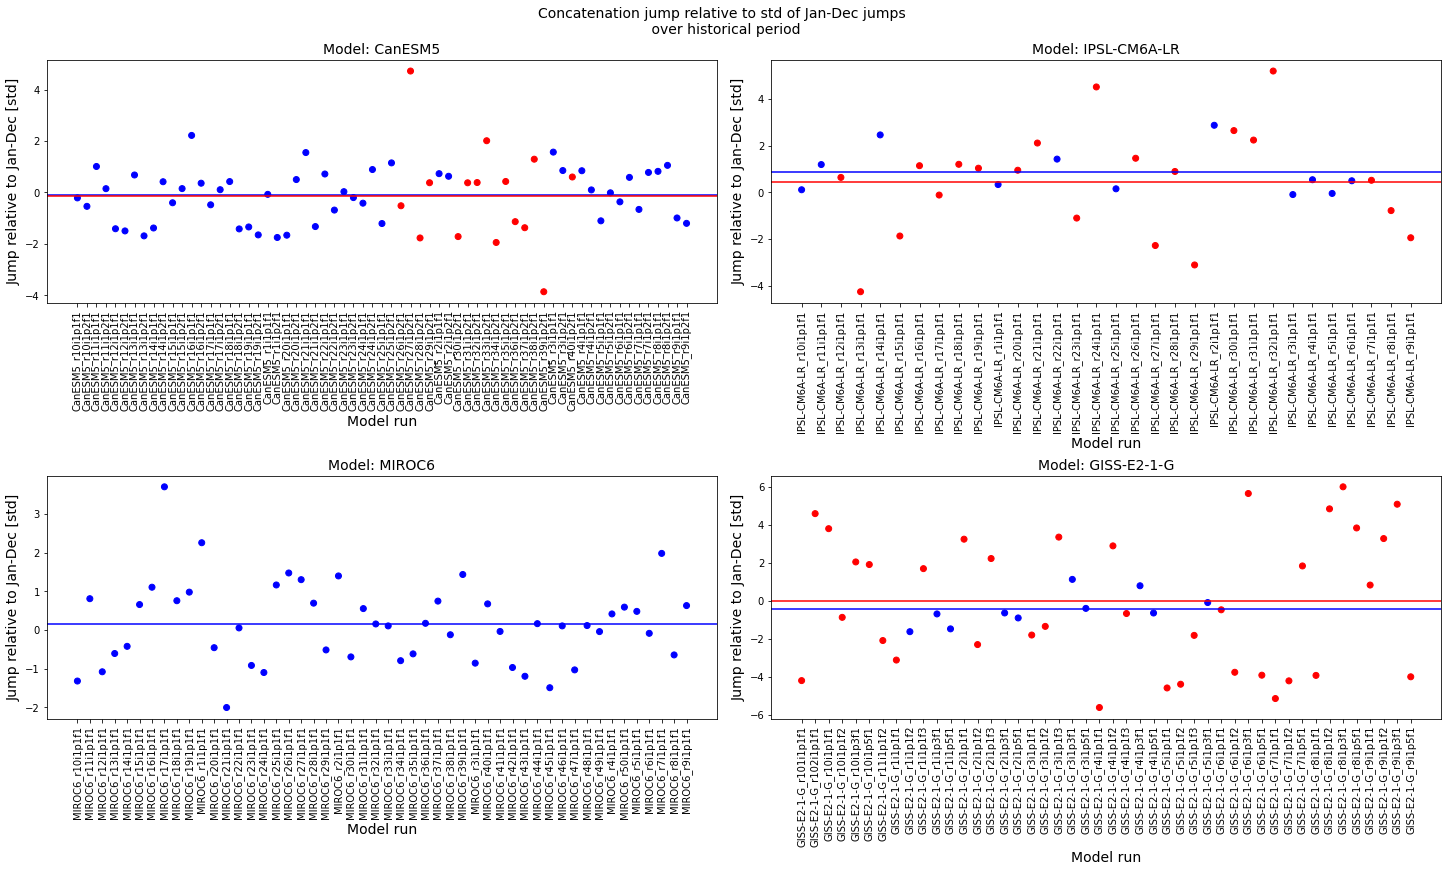

In [563]:
# for loop for all four models
nFigures = len(models)
nCols = 2

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (10, 6)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]
fig = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig.suptitle('Concatenation jump relative to std of Jan-Dec jumps \n over historical period', fontsize = 14)

for i, model in enumerate(models):
    # creating the axes
    ax = fig.add_subplot(nRows, nCols, i+1)
    
    # filtering the dataframe for the model
    dfOneModel = matchData[matchData.Model == model]
    
    # calculating the mean by assignment
    try:
        meanNonRandom = dfOneModel.groupby('Assignment').ConcatJumpJanDec.mean()['Non-random']
    except Exception:
        meanNonRandom = np.nan
    
    try:
        meanRandom = dfOneModel.groupby('Assignment').ConcatJumpJanDec.mean()['Random']
    except Exception:
        meanRandom = np.nan

    # plotting the scatter plot from the dataframe
    ax.scatter(dfOneModel.index, dfOneModel.ConcatJumpJanDec, c = dfOneModel.Colour_Assignment)
    ax.set_title(f'Model: {model}', fontsize = 14)
    ax.set_xlabel('Model run', fontsize = 14)
    ax.set_ylabel('Jump relative to Jan-Dec [std]', fontsize = 14)
    ax.set_xticks(range(len(dfOneModel.index)))
    ax.set_xticklabels(dfOneModel.index, rotation = 90)
    ax.axhline(y = meanNonRandom, color = 'Blue')
    ax.axhline(y = meanRandom, color = 'Red')

plt.show()

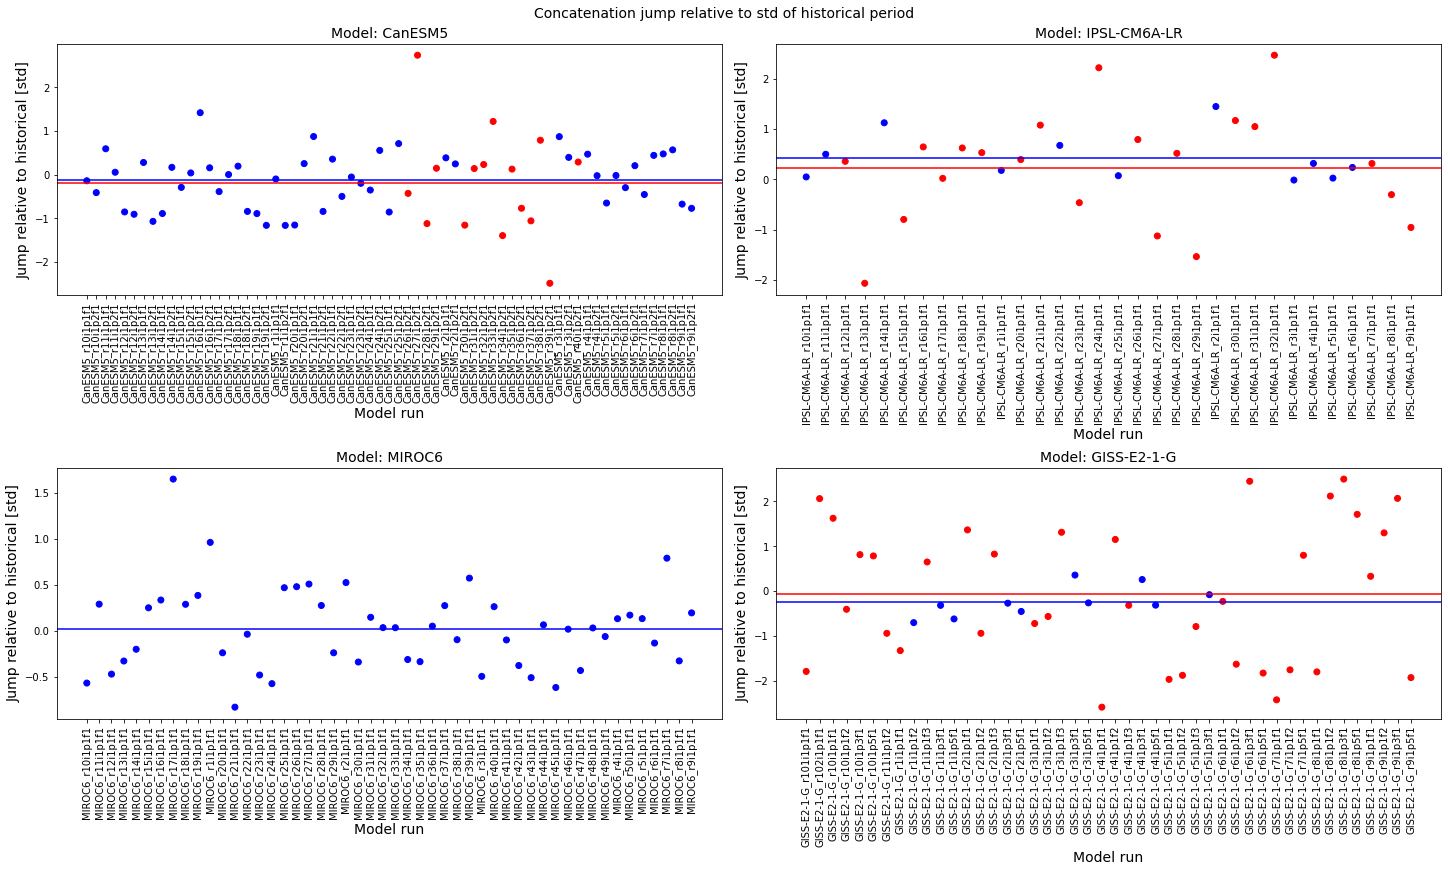

In [575]:
# for loop for all four models
nFigures = len(models)
nCols = 2

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (10, 6)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]
fig = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig.suptitle('Concatenation jump relative to std of historical period', fontsize = 14)

for i, model in enumerate(models):
    # creating the axes
    ax = fig.add_subplot(nRows, nCols, i+1)
    
    # filtering the dataframe for the model
    dfOneModel = matchData[matchData.Model == model]
    
    # calculating the mean by assignment
    try:
        meanNonRandom = dfOneModel.groupby('Assignment').ConcatJumpHist.mean()['Non-random']
    except Exception:
        meanNonRandom = np.nan
    
    try:
        meanRandom = dfOneModel.groupby('Assignment').ConcatJumpHist.mean()['Random']
    except Exception:
        meanRandom = np.nan

    # plotting the scatter plot from the dataframe
    ax.scatter(dfOneModel.index, dfOneModel.ConcatJumpHist, c = dfOneModel.Colour_Assignment)
    ax.set_title(f'Model: {model}', fontsize = 14)
    ax.set_xlabel('Model run', fontsize = 14)
    ax.set_ylabel('Jump relative to historical [std]', fontsize = 14)
    ax.set_xticks(range(len(dfOneModel.index)))
    ax.set_xticklabels(dfOneModel.index, rotation = 90)
    ax.axhline(y = meanNonRandom, color = 'Blue')
    ax.axhline(y = meanRandom, color = 'Red')

plt.show()

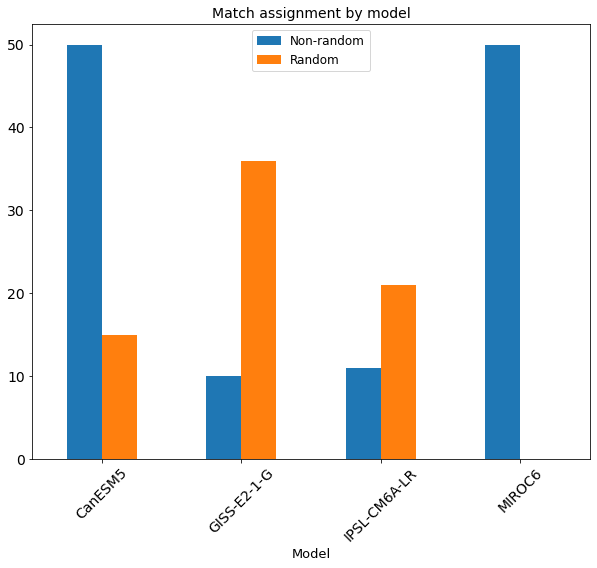

In [572]:
fig, ax = plt.subplots(figsize = (10,8))
dfGrouped = matchData.groupby(['Model', 'Assignment']).size().reset_index(name = 'Counts')
plot = dfGrouped.pivot_table(index = 'Model', columns = 'Assignment', fill_value = 0).plot(kind = 'bar', ax = ax, fontsize = 14)
plot.set_title('Match assignment by model', fontsize = 14)
plot.legend(['Non-random', 'Random'], fontsize = 12)
plot.set_xlabel('Model', fontsize = 13)
plot.set_xticklabels(ax.get_xticklabels(minor = False), rotation = 45)
plt.show()

In [570]:
dfGrouped

,Model,Assignment,Counts
0,CanESM5,Non-random,50
1,CanESM5,Random,15
2,GISS-E2-1-G,Non-random,10
3,GISS-E2-1-G,Random,36
4,IPSL-CM6A-LR,Non-random,11
5,IPSL-CM6A-LR,Random,21
6,MIROC6,Non-random,50


# working on recreating the GISS trends to check if I'm doing it right

In [15]:
# concatenating the models
# do this for just one of the GISS runs

modelGISS = ConcatModels(histModelsTest['GISS-E2-1-G_r101i1p1f1'])

In [35]:
# slice into regions and calculate the gradient
lonminE, lonmaxE = 190, 270
latminE, latmaxE = -3,3

# region_West
lonminW, lonmaxW = 140, 170
latminW, latmaxW = -3, 3

GISSe = modelGISS.ts.sel(lat = slice(latminE, latmaxE), lon = slice(lonminE, lonmaxE))
GISSw = modelGISS.ts.sel(lat = slice(latminW, latmaxW), lon = slice(lonminW, lonmaxW))

# calculating the area-weighted average values for these regions
weightsE = np.cos(np.radians(GISSe.lat))
weightsW = np.cos(np.radians(GISSw.lat))

GISSeMean = GISSe.weighted(weightsE).mean(dim = ('lat', 'lon'))
GISSwMean = GISSw.weighted(weightsW).mean(dim = ('lat', 'lon'))

# calculating the gradient
GISSgradient = GISSwMean - GISSeMean

# now calculating all of the trends in this gradient
startYear = 1870
endYear = 2023
minTrend = 20 # years

# initialising a dictionary to hold the trends
GISStrends = {}

for startyear in range(startYear, endYear - minTrend + 1):
    for endyear in range(startYear + minTrend, endYear + 1):
        if endyear < startyear+minTrend:
            GISStrends{startyear, endyear} = np.nan
        else:
            subsettime

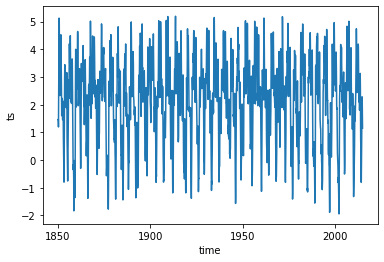

In [36]:
GISSgradient.plot()

## Creating an exception for EC-Earth3

In [103]:
# inputting from a csv file
directory = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

# inputting the historical data
fileName = 'cmip6_historical_opendap.csv'
os.chdir(directory)
inputHist = pd.read_csv(fileName)

# inputting the scenario data
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputScenario = pd.read_csv(fileName)

# selecting the models
#models = ['MIROC6', 'CanESM5', 'GISS-E2-1-G', 'IPSL-CM6A-LR']
models = ['EC-Earth3']

# filtering for the subset of links we are interested in
# first filtering the Scenario datasets because these are more limited
scenarioFilt = inputScenario[(inputScenario['experiment_id'] == 'ssp245') &
                             (inputScenario['variable_id'] == 'ts') &
                             ((inputScenario['grid_label'] == 'gn') |
                             (inputScenario['grid_label'] == 'gr'))
                            ]

# filtering the historical datasets based on which also have scenarios
histFilt = inputHist[inputHist['source_id'].isin(models) &
                     (inputHist['variable_id'] == 'ts') & 
                     ((inputHist['grid_label'] == 'gn') |
                     (inputHist['grid_label'] == 'gr'))
                    ]

# then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

# saving all of the urls into one list
modelListHist = histFilt['URL'].tolist()
modelListScenario = scenarioFilt['URL'].tolist()

In [106]:
histModelsTest = ClassifyHistModelsLite(modelListHist)

In [107]:
scenarioModelsTest = CreateScenarioDictionaryLite(modelListScenario)

In [108]:
scenarioModelsTest

{'EC-Earth3_r10i1p1f1': ['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r10i1p1f1/Amon/ts/gr/v20200215/ts_Amon_EC-Earth3_ssp245_r10i1p1f1_gr_201501-201512.nc',
  'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r10i1p1f1/Amon/ts/gr/v20200215/ts_Amon_EC-Earth3_ssp245_r10i1p1f1_gr_201601-201612.nc',
  'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r10i1p1f1/Amon/ts/gr/v20200215/ts_Amon_EC-Earth3_ssp245_r10i1p1f1_gr_201701-201712.nc',
  'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r10i1p1f1/Amon/ts/gr/v20200215/ts_Amon_EC-Earth3_ssp245_r10i1p1f1_gr_201801-201812.nc',
  'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp245/r10i1p1f1/Amon/ts/gr/v20200215/ts_Amon_EC-Earth3_ssp245_r10i1p1f1_gr_201901-201912.nc',
  'http://mary.ldeo.columbia.edu

In [19]:
## second attempt at this where we are only including relevant periods to make it faster

scenarioModels = defaultdict(list)

# dates for checking that the scenario fits into the right time
nModels = len(modelListScenario)
start_year = 2015
monStart = 1
dayStart = 31 # because these are sometimes on the 16th of the month
end_year = 2023
monEnd = 12
dayEnd = 1  # because these are sometimes on the 16th of the month as well


counter = 0
for model in modelListScenario:
    
    # opening the file
    ds = xr.open_dataset(model)
    sourceID = ds.attrs['source_id']
    memberVariant = ds.attrs['variant_label']
    scenarioID = sourceID + '_' + memberVariant

    # checking the timing
    # run two versions of checking depending on the format that the date time information is in
    if isinstance(ds.time.values[0], np.datetime64):
            start_date = np.datetime64(f'{start_year}-{monStart:02d}-{dayStart:02d}')
            end_date = np.datetime64(f'{end_year}-{monEnd:02d}-{dayEnd:02d}')            

    elif isinstance(ds.time.values[0], cftime.DatetimeNoLeap):
        start_date = cftime.DatetimeNoLeap(start_year, monStart, dayStart)
        end_date = cftime.DatetimeNoLeap(end_year, monEnd, dayEnd)
        
    # first option: scenario is at the start of the period
    if (ds.time[0] <= start_date):
        # append the value to the list using the source_id as the key
        scenarioModels[scenarioID].append(model)
    
    # second option: it ends before the end date of the period (so these are shorter ones that aren't the first)
    elif (ds.time[0] <= end_date):
        scenarioModels[scenarioID].append(model)

    print (f'{counter} / {nModels}')
    counter += 1

scenarioModels = dict(scenarioModels)

0 / 1837
1 / 1837
2 / 1837
3 / 1837
4 / 1837
5 / 1837
6 / 1837
7 / 1837
8 / 1837
9 / 1837
10 / 1837
11 / 1837
12 / 1837
13 / 1837
14 / 1837
15 / 1837
16 / 1837
17 / 1837
18 / 1837
19 / 1837
20 / 1837
21 / 1837
22 / 1837
23 / 1837
24 / 1837
25 / 1837
26 / 1837
27 / 1837
28 / 1837
29 / 1837
30 / 1837
31 / 1837
32 / 1837
33 / 1837
34 / 1837
35 / 1837
36 / 1837
37 / 1837
38 / 1837
39 / 1837
40 / 1837
41 / 1837
42 / 1837
43 / 1837
44 / 1837
45 / 1837
46 / 1837
47 / 1837
48 / 1837
49 / 1837
50 / 1837
51 / 1837
52 / 1837
53 / 1837
54 / 1837
55 / 1837
56 / 1837
57 / 1837
58 / 1837
59 / 1837
60 / 1837
61 / 1837
62 / 1837
63 / 1837
64 / 1837
65 / 1837
66 / 1837
67 / 1837
68 / 1837
69 / 1837
70 / 1837
71 / 1837
72 / 1837
73 / 1837
74 / 1837
75 / 1837
76 / 1837
77 / 1837
78 / 1837
79 / 1837
80 / 1837
81 / 1837
82 / 1837
83 / 1837
84 / 1837
85 / 1837
86 / 1837
87 / 1837
88 / 1837
89 / 1837
90 / 1837
91 / 1837
92 / 1837
93 / 1837
94 / 1837
95 / 1837
96 / 1837
97 / 1837
98 / 1837
99 / 1837
100 / 1837

KeyboardInterrupt: 

In [10]:
scenarioModels = defaultdict(list)

counter = 0
for model in modelListScenario[:100]:
    ds = xr.open_dataset(model)
    sourceID = ds.attrs['source_id']
    memberVariant = ds.attrs['variant_label']
    scenarioID = sourceID + '_' + memberVariant

    scenarioModels[scenarioID].append(model)
    print (f'{counter} / {len(modelListScenario)}')
    counter += 1

    
scenarioModels = dict(scenarioModels)

0 / 1837
1 / 1837
2 / 1837
3 / 1837
4 / 1837
5 / 1837
6 / 1837
7 / 1837
8 / 1837
9 / 1837
10 / 1837
11 / 1837
12 / 1837
13 / 1837
14 / 1837
15 / 1837
16 / 1837
17 / 1837
18 / 1837
19 / 1837
20 / 1837
21 / 1837
22 / 1837
23 / 1837
24 / 1837
25 / 1837
26 / 1837
27 / 1837
28 / 1837
29 / 1837
30 / 1837
31 / 1837
32 / 1837
33 / 1837
34 / 1837
35 / 1837
36 / 1837
37 / 1837
38 / 1837
39 / 1837
40 / 1837
41 / 1837
42 / 1837
43 / 1837
44 / 1837
45 / 1837
46 / 1837
47 / 1837
48 / 1837
49 / 1837
50 / 1837
51 / 1837
52 / 1837
53 / 1837
54 / 1837
55 / 1837
56 / 1837
57 / 1837
58 / 1837
59 / 1837
60 / 1837
61 / 1837
62 / 1837
63 / 1837
64 / 1837
65 / 1837
66 / 1837
67 / 1837
68 / 1837
69 / 1837
70 / 1837
71 / 1837
72 / 1837
73 / 1837
74 / 1837
75 / 1837
76 / 1837
77 / 1837
78 / 1837
79 / 1837
80 / 1837
81 / 1837
82 / 1837
83 / 1837
84 / 1837
85 / 1837
86 / 1837
87 / 1837
88 / 1837
89 / 1837
90 / 1837
91 / 1837
92 / 1837
93 / 1837
94 / 1837
95 / 1837
96 / 1837
97 / 1837
98 / 1837
99 / 1837


In [12]:
ModelInput?

Init signature: ModelInput(modelID)
Docstring:      <no docstring>
Init docstring:
Takes the input of a modelID (in this case URL), reads in the data and checks the coordinates (makes sure it's lat and lon)
:param modelID: A unique ID for the model in the form of an openDAP url or in the form of the dataset itself (to handle the cases where models have been concatenated), or in some cases a list of URLs (for the cases where scenarios were not the full period)
File:           ~/Research/Gradient_project/gradient_project/GradTrendClasses.py
Type:           type
Subclasses:     


In [13]:
testInput = ModelInput(scenarioModels['EC-Earth3_r10i1p1f1'])

In [18]:
testInput.ds

<xarray.Dataset>
Dimensions:    (time: 1032, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(12, 512, 2), meta=np.ndarray>
    ts         (time, lat, lon) float32 dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    branch_time:                     0.0
    contact:                         cmip6-data@ec-earth.org
    creation_date:                   2019-10-05T18:16:10Z
    data_specs_version:              01.00.27
    external_variables:              areacella
    ...                              ...
    branch_time_in_child:            60265.0
    nominal_resolution:              100 km
    history:                         Tue Nov 19 15:46:49 2019: ncatted -O -a ...
    tracking_id:                     hdl:21.14100/c342f2d1-7a80-43a7-8d67-6d7...
    parent_variant_label:            r1i1p1f1
    DODS_EXTRA.Unlimited_Dimension:  time

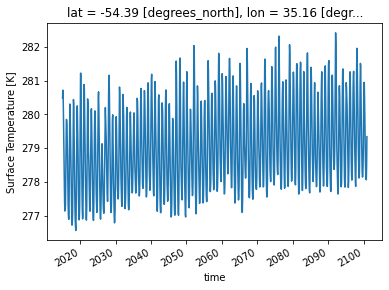

In [16]:
testInput.ds.ts.isel(lat = 50, lon = 50).plot()

In [79]:
dsECScenario = xr.open_mfdataset(listECScenario, use_cftime = False)

In [84]:
dsECScenario.ts.sel(lat = slice(0,10), lon = slice(0,10)).mean().compute()

<xarray.DataArray 'ts' ()>
array(301.19626, dtype=float32)

In [86]:
test2 = xr.open_dataset(modelListScenario[0])

In [88]:
test2.ts.sel(lat = slice(0,10), lon = slice(0,10)).mean().compute()

<xarray.DataArray 'ts' ()>
array(300.80487, dtype=float32)

In [8]:
len(modelListScenario)

1837

## Messing around with pooch

#### Hadley

In [77]:
import pooch

In [78]:
file_path = pooch.retrieve(
url = 'https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz',
known_hash = 'sha256:b03d7c0adcdc29b1687ee2bb22c322a6019547aee3339f29af0a6dc505e7477f'
)

In [79]:
odie = pooch.create(
    path = pooch.os_cache('HadISST'),
    base_url = 'https://www.metoffice.gov.uk/hadobs/hadisst/data/',
    registry = {
        'HadISST_sst.nc.gz': 'sha256:b03d7c0adcdc29b1687ee2bb22c322a6019547aee3339f29af0a6dc505e7477f'
    },
)

In [63]:
file_path = odie.fetch('HadISST_sst.nc.gz')

In [64]:
data = xr.open_dataset(file_path)

#### Cobe 2

In [93]:
# trying the same for COBE 2

file_path = pooch.retrieve(
url = 'https://downloads.psl.noaa.gov//Datasets/COBE2/sst.mon.mean.nc',
known_hash = 'sha256:a49845ef5dbd73223edaf7d131646534738f7262f4c17eb3fa864759cfa53471'
)

In [94]:
odie = pooch.create(
path = pooch.os_cache('PacificGradientProject'),
    base_url = 'https://downloads.psl.noaa.gov//Datasets/COBE2/',
    registry = {
        'sst.mon.mean.nc': 'sha256:a49845ef5dbd73223edaf7d131646534738f7262f4c17eb3fa864759cfa53471'
    },
)

In [95]:
file_path = odie.fetch('sst.mon.mean.nc')

In [96]:
data = xr.open_dataset(file_path)

In [98]:
test = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/COBE2/sst.mon.mean.nc')

In [99]:
test

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 2092)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-04-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:                           created 12/2013 from data provided by JRA
    history:                         Created 12/2012 from data obtained from ...
    platform:                        Analyses
    citation:                        Hirahara, S., Ishii, M., and Y. Fukuda,2...
    institution:                     NOAA ESRL/PSD
    Conventions:                     CF-1.2
    dataset_title:                   COBE-SST2 Sea Surface Temperature and Ice
    original_source:                 https://climate.mri-jma.go.jp/pub/ocean/...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/cob...
    DODS_EXTRA.Unlimited_Dimension:  time

#### Cobe 

In [101]:
openDap = 'http://psl.noaa.gov/thredds/dodsC/Datasets/COBE/sst.mon.mean.nc'

#### Kaplan

In [102]:
openDap = 'http://psl.noaa.gov/thredds/dodsC/Datasets/kaplan_sst/sst.mean.anom.nc'

## Creating concat models lite

In [71]:
def ConcatModelsLite(modelList):
    
    '''
    For the models that weren't complete from the classify models stage (i.e., didn't cover the full period), concatenate all of the models saved; in the Lite version we are using open_mfdataset instead of the full concatenation piece by piece
    
    Inputs:
        modelList: a list pertaining to a specific model (i.e., from the output of ClassifyModels, this should be modelsDict['Name of model'], which will be a list of urls)
        
    Outputs:
        a full xarray dataset that has been concatenated to the full length; note that it will be chunked 
    
    '''
    # open one of the datasets
    ds = xr.open_mfdataset(modelList)

    # run a check to make sure that the dataset encompasses the full period
    start_year = 1850
    monStart = 1
    dayStart = 31 # because these are sometimes on the 16th of the month
    end_year = 2014
    monEnd = 12
    dayEnd = 1  # because these are sometimes on the 16th of the month as well
    
    # run two versions of checking depending on the format that the date time information is in
    if isinstance(ds.time.values[0], np.datetime64):
            start_date = np.datetime64(f'{start_year}-{monStart:02d}-{dayStart:02d}')
            end_date = np.datetime64(f'{end_year}-{monEnd:02d}-{dayEnd:02d}')            

    elif isinstance(ds.time.values[0], cftime.DatetimeNoLeap):
        start_date = cftime.DatetimeNoLeap(start_year, monStart, dayStart)
        end_date = cftime.DatetimeNoLeap(end_year, monEnd, dayEnd)

    # return the full model
    if (ds.time[0] <= start_date) & (ds.time[-1] >= end_date):
        return ds

    # run an error message if the datasets are incomplete
    else:
        raise ValueError('Concatenated models do not span full period')
    
    return ds

In [69]:
histModels = ClassifyHistModelsLite(modelListHist)

In [75]:
import time

start_time1 = time.time()

dsTest = ConcatModelsLite(histModels['EC-Earth3_r10i1p1f1'])

end_time1 = time.time()

elapsed_time1 = end_time1 - start_time1

print(f'ConcatModelsLite: {elapsed_time1}')

start_time2 = time.time()

dsTest2 = ConcatModels(histModels['EC-Earth3_r10i1p1f1'])

end_time2 = time.time()

elapsed_time2 = end_time2 - end_time1

print(f'ConcatModels: {elapsed_time2}')

ConcatModelsLite: 369.18756079673767
ConcatModels: 582.7302358150482


In [118]:
test = ModelInput(histModels['EC-Earth3_r3i1p1f1'])

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Error loading data for model ['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r3i1p1f1/Amon/ts/gr/v20200730/ts_Amon_EC-Earth3_historical_r3i1p1f1_gr_185001-185012.nc', 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r3i1p1f1/Amon/ts/gr/v20200730/ts_Amon_EC-Earth3_historical_r3i1p1f1_gr_185101-185112.nc', 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r3i1p1f1/Amon/ts/gr/v20200730/ts_Amon_EC-Earth3_historical_r3i1p1f1_gr_185201-185212.nc', 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r3i1p1f1/Amon/ts/gr/v20200730/ts_Amon_EC-Earth3_historical_r3i1p1f1_gr_185301-185312.nc', 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r3i1p1f1/Amon/ts/gr/v20200730/ts_Amon_EC-Earth3_historical_r3i1p1f1_gr_185401-185412.nc', 'http://mary.ldeo.columbia.edu:8080/open

AttributeError: 'ModelInput' object has no attribute 'ds'

In [116]:
histModels.keys()

dict_keys(['EC-Earth3_r10i1p1f1', 'EC-Earth3_r13i1p1f1', 'EC-Earth3_r14i1p1f1', 'EC-Earth3_r15i1p1f1', 'EC-Earth3_r16i1p1f1', 'EC-Earth3_r17i1p1f1', 'EC-Earth3_r18i1p1f1', 'EC-Earth3_r1i1p1f1', 'EC-Earth3_r21i1p1f1', 'EC-Earth3_r22i1p1f1', 'EC-Earth3_r23i1p1f1', 'EC-Earth3_r24i1p1f1', 'EC-Earth3_r25i1p1f1', 'EC-Earth3_r2i1p1f1', 'EC-Earth3_r3i1p1f1', 'EC-Earth3_r4i1p1f1', 'EC-Earth3_r6i1p1f1', 'EC-Earth3_r7i1p1f1', 'EC-Earth3_r9i1p1f1'])

## Creating a new function to get model input from openDap

In [119]:

def SelectOpenDAPModels(openDapDir = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs', histFile = 'cmip6_historical_opendap.csv', scenFile = 'cmip6_ScenarioMIP_opendap.csv', models = ['MIROC6'], scenario = 'ssp245'):
    '''
    Function that takes in arguments and outputs a list of Historical model URLs and a list of Scenario model URLs based on the parameters passed.
    
    Inputs:
        openDapDir: directory with the openDAP url files
        histFile: filename for the csv with the openDap urls for historical models
        scenFile: filename for the csv with the openDap urls for scenario models
        models: list of model names
        scenario: name of the scenario we're looking at
    
    '''
    # inputting from a csv file

    # inputting the historical data
    fileName = histFile
    os.chdir(openDapDir)
    inputHist = pd.read_csv(fileName)

    # inputting the scenario data
    fileName = scenFile
    inputScenario = pd.read_csv(fileName)

    # filtering for the subset of links we are interested in
    # first filtering the Scenario datasets because these are more limited
    scenarioFilt = inputScenario[(inputScenario['experiment_id'] == scenario) &
                                 (inputScenario['variable_id'] == 'ts') &
                                 ((inputScenario['grid_label'] == 'gn') |
                                 (inputScenario['grid_label'] == 'gr') |
                                 (inputScenario['grid_label'] == 'gr1'))
                                ]

    # filtering the historical datasets based on which also have scenarios
    histFilt = inputHist[inputHist['source_id'].isin(models) &
                         (inputHist['variable_id'] == 'ts') & 
                         ((inputHist['grid_label'] == 'gn') |
                          (inputHist['grid_label'] == 'gr') |
                          (inputHist['grid_label'] == 'gr1'))
                        ]

    # then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
    scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

    # saving all of the urls into one list
    modelListHist = histFilt['URL'].tolist()
    modelListScenario = scenarioFilt['URL'].tolist()
    
    return modelListHist, modelListScenario

In [125]:
histTest, scenTest = SelectOpenDAPModels(models = ['CanESM5'], scenario='ssp370')

In [126]:
scenTest

['http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r10i1p1f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp370_r10i1p1f1_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r10i1p2f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp370_r10i1p2f1_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r11i1p1f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp370_r11i1p1f1_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r11i1p2f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp370_r11i1p2f1_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r12i1p1f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp370_r12i1p1f1_gn_201501-210012.nc',
 'http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r12i1p2f1/Amon/ts/gn/v20190429/ts_Amon_CanESM5_ssp370_r12i1p2f1_gn

## Investigating the effects of averaging

#### Approach 1: Doing each of them individually; using the MIROC6 model (no random)

In [132]:
# selecting the MIROC models
modelListHist, modelListScenario = SelectModelInputs(models = ['MIROC6'])

In [133]:
# classifying the models
histModels = ClassifyHistModelsLite(modelListHist)
scenarioModels = CreateScenarioDictionaryLite(modelListScenario)

In [152]:
# now joining the models etc.

# calculating and storing the trends

# setting the minimum trend
minTrend = 20 # years

# creating a dictionary to store all of the trends information and attributes:
matchDict = {} # dictionary to store information about random versus non-random matches; NOTE that output here is Model Name and variant label for the scenario (i.e., not parent variant label)
counter = 0
modelCount = len(histModels.keys())

# setting the extent to cut down the data
lonminE, lonmaxE = 190, 270
latminE, latmaxE = -3,3

# region_West
lonminW, lonmaxW = 140, 170
latminW, latmaxW = -3, 3

for key in histModels:
    
    if key == 'Full':
        for model in histModels[key]:
            # loading and checking the data
            modelInput = ModelInput(model)
            
            # extending the model period through adding in scenarios
            modelIdentifier = modelInput.ds.attrs['source_id'] + '_' + modelInput.ds.attrs['variant_label']
            modelFullPeriod, match = ExtendPeriod(modelIdentifier, modelInput, scenarioModels)
            matchDict[modelIdentifier] = match
            
            # cutting down the data
            modelFullPeriodE = modelFullPeriod.sel(lat = slice(latminE, latmaxE), lon = slice(lonminE, lonmaxE), time = slice('1860', '2024')).ts
            modelFullPeriodW = modelFullPeriod.sel(lat = slice(latminW, latmaxW), lon = slice(lonminW, lonmaxW), time = slice('1860', '2024')).ts
            
            if counter == 0:
                daCumulativeE = modelFullPeriodE
                daCumulativeW = modelFullPeriodW
                
            else:
                daCumulativeE += modelFullPeriodE
                daCumulativeW += modelFullPeriodW
                
            
            counter += 1
            
    
    else:
        # concatenating to the length of the initial period
        model = ConcatModels(histModels[key])
        
        # loading and checking the data
        modelInput = ModelInput(model)
        
        # extending the model period through adding in scenarios
        modelFullPeriod, match = ExtendPeriod(key, modelInput, scenarioModels)
        matchDict[key] = match
        
        # cutting down the data
        modelFullPeriodE = modelFullPeriod.sel(lat = slice(latminE, latmaxE), lon = slice(lonminE, lonmaxE), time = slice('1860', '2024')).ts
        modelFullPeriodW = modelFullPeriod.sel(lat = slice(latminW, latmaxW), lon = slice(lonminW, lonmaxW), time = slice('1860', '2024')).ts
        if counter == 0:
            daCumulativeE = modelFullPeriodE
            daCumulativeW = modelFullPeriodW

        else:
            daCumulativeE += modelFullPeriodE
            daCumulativeW += modelFullPeriodW
        
        
    counter += 1
    print(f'{counter} / {modelCount}')
    


('MIROC6_r10i1p1f1', 'Non-random')
1 / 50
('MIROC6_r11i1p1f1', 'Non-random')
2 / 50
('MIROC6_r12i1p1f1', 'Non-random')
3 / 50
('MIROC6_r13i1p1f1', 'Non-random')
4 / 50
('MIROC6_r14i1p1f1', 'Non-random')
5 / 50
('MIROC6_r15i1p1f1', 'Non-random')
6 / 50
('MIROC6_r16i1p1f1', 'Non-random')
7 / 50
('MIROC6_r17i1p1f1', 'Non-random')
8 / 50
('MIROC6_r18i1p1f1', 'Non-random')
9 / 50
('MIROC6_r19i1p1f1', 'Non-random')
10 / 50
('MIROC6_r1i1p1f1', 'Non-random')
11 / 50
('MIROC6_r20i1p1f1', 'Non-random')
12 / 50
('MIROC6_r21i1p1f1', 'Non-random')
13 / 50
('MIROC6_r22i1p1f1', 'Non-random')
14 / 50
('MIROC6_r23i1p1f1', 'Non-random')
15 / 50
('MIROC6_r24i1p1f1', 'Non-random')
16 / 50
('MIROC6_r25i1p1f1', 'Non-random')
17 / 50
('MIROC6_r26i1p1f1', 'Non-random')
18 / 50
('MIROC6_r27i1p1f1', 'Non-random')
19 / 50
('MIROC6_r28i1p1f1', 'Non-random')
20 / 50
('MIROC6_r29i1p1f1', 'Non-random')
21 / 50
('MIROC6_r2i1p1f1', 'Non-random')
22 / 50
('MIROC6_r30i1p1f1', 'Non-random')
23 / 50
('MIROC6_r31i1p1f1', '

In [199]:
daMeanE = daCumulativeE / 50
daMeanW = daCumulativeW / 50

In [200]:
# now for each region removing the climatology
daSstaE = RemoveClimatology(daMeanE)
daSstaW = RemoveClimatology(daMeanW)

In [201]:
# now calculating the gradient
gradient = daSstaW.mean(dim = ['lat', 'lon']) - daSstaE.mean(dim = ['lat', 'lon'])

In [202]:
# now calculating the trends
dsGradient = xr.Dataset(
                        {
                            'gradient': (['time'], gradient.values),
                            'modelName': ('MIROC6'),
                        },
                        coords = {
                            'time': gradient.time
                        })

In [203]:
trend = Trend(dsGradient, minTrend, 1870, 2023)

In [204]:
trendDf1 = trend.trendsDf

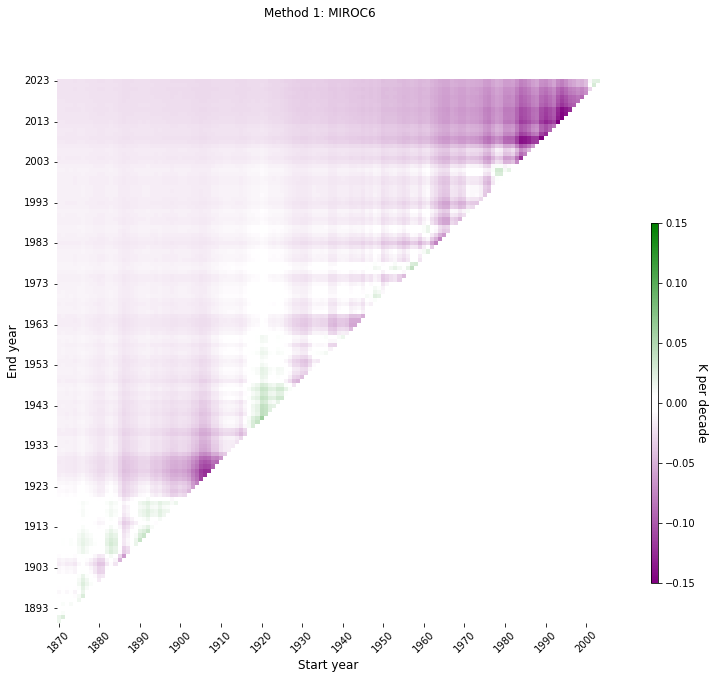

In [207]:
fig = plt.figure(figsize = (10,10))
fig.suptitle('Method 1: MIROC6')

vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
vmax = -vmin

# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plot = sns.heatmap(trendDf1, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 12)
ax.set_xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.96, 0.18, 0.01, 0.5])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 12, fontsize = 12)

#### Method 2: Calculating the mean of the gradients

In [216]:
meanGradient = CalculateMMEGradient('/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_NonParent_All', 'MIROC6')

In [217]:
trendDf2 = Trend(meanGradient, minTrend, 1870, 2023).trendsDf

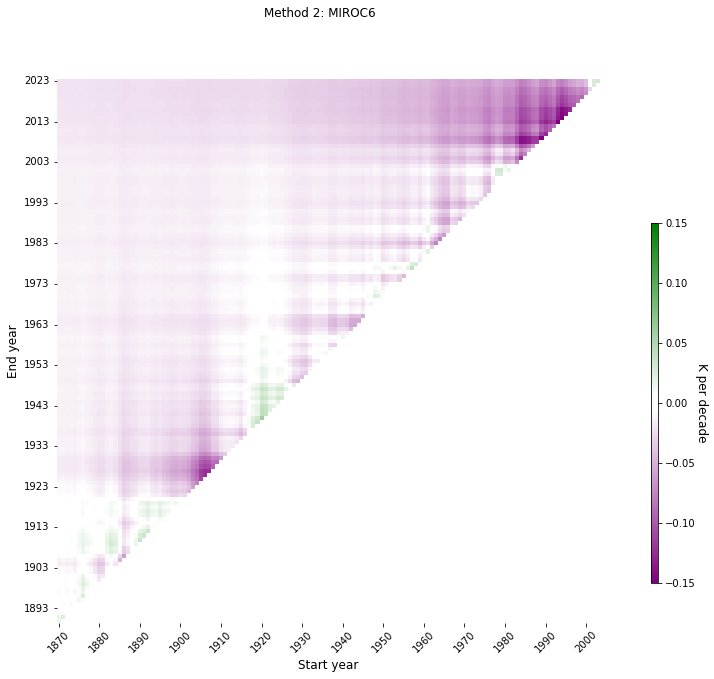

In [218]:
fig = plt.figure(figsize = (10,10))
fig.suptitle('Method 2: MIROC6')

vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
vmax = -vmin

# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plot = sns.heatmap(trendDf2, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 12)
ax.set_xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.96, 0.18, 0.01, 0.5])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 12, fontsize = 12)

#### Method 3: Calculating by averaging all trends

In [223]:
dirTrends = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends_NonParent_All'
model = 'MIROC6'

os.chdir(dirTrends)
trendsFiles = os.listdir(dirTrends)
trendsDfs = [pd.read_csv(trendsFile, index_col = 0) for trendsFile in trendsFiles if '.csv' in trendsFile and model in trendsFile]
trendDf3 = sum(trendsDfs) / len(trendsDfs)

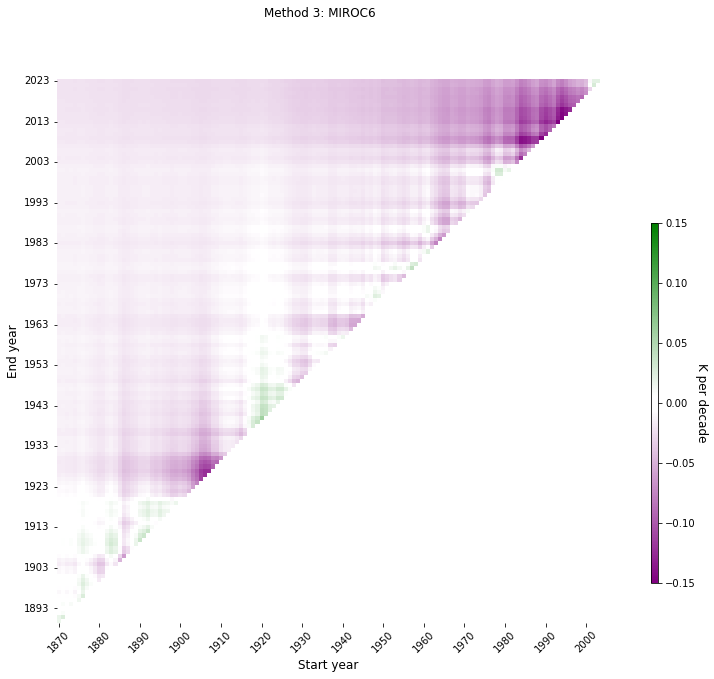

In [224]:
fig = plt.figure(figsize = (10,10))
fig.suptitle('Method 3: MIROC6')

vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
vmax = -vmin

# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plot = sns.heatmap(trendDf3, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 12)
ax.set_xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.96, 0.18, 0.01, 0.5])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 12, fontsize = 12)

#### differencing

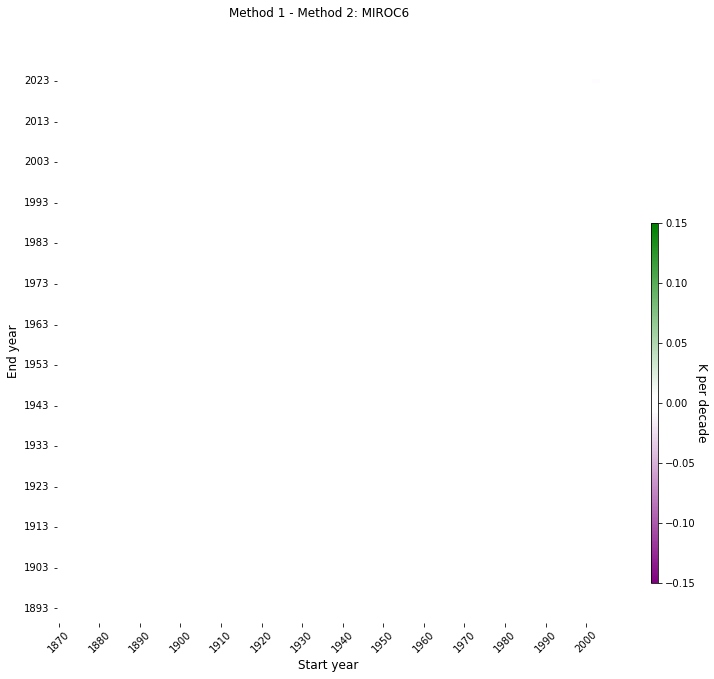

In [229]:
diff1 = trendDf1 - trendDf2

fig = plt.figure(figsize = (10,10))
fig.suptitle('Method 1 - Method 2: MIROC6')

vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
vmax = -vmin

# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plot = sns.heatmap(diff1, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 12)
ax.set_xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.96, 0.18, 0.01, 0.5])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 12, fontsize = 12)

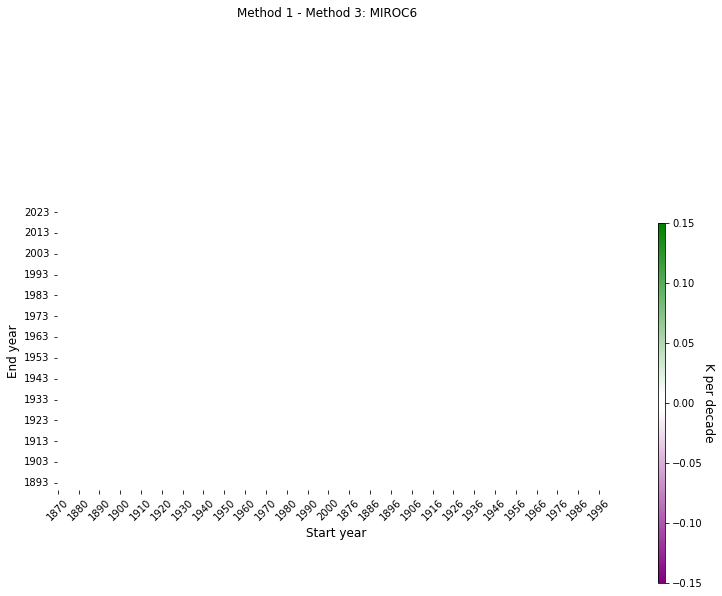

In [227]:
diff2 = trendDf1 - trendDf3

fig = plt.figure(figsize = (10,10))
fig.suptitle('Method 1 - Method 3: MIROC6')

vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
vmax = -vmin

# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plot = sns.heatmap(diff2, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 12)
ax.set_xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.96, 0.18, 0.01, 0.5])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 12, fontsize = 12)

In [264]:
type(trendDf3.loc[2023, '1870'])

numpy.float64

In [265]:
type(trendDf1.loc[2023, '1870'])

KeyError: '1870'

In [274]:
trendDf3 - trendDf1

,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,...,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003
end_year,,,,,,,,,,,,,,,,,,,,,
2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
trendDf1.columns

Int64Index([1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879,
            ...
            1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003],
           dtype='int64', name='start_year', length=134)

In [301]:
np.nanstd(list(trendDf2.values - trendDf3.values))

0.00013557423689908863

In [309]:
test = RemoveClimatology(daCumulative)

In [310]:
daCumulative

<xarray.Dataset>
Dimensions:    (time: 2280, bnds: 2, lat: 128, lon: 256)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2039-12-16T12:00:00
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1850-01-01 1850-02-01 ... 2040-01-01
    lat_bnds   (time, lat, bnds) float64 -90.0 -88.28 -88.28 ... 88.28 90.0
    lon_bnds   (time, lon, bnds) float64 -0.7031 0.7031 0.7031 ... 357.9 359.3
    ts         (time, lat, lon) float32 258.3 258.3 258.2 ... 249.6 249.6 249.6
Attributes: (12/45)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           98616.0
    creation_date:                   2018-12-01T00:53:53Z
    ...                              ...
    variable_id:                     ts
    variant_label:                   r10i1p1f1
    license:                         CMIP6 model data produced by MIROC is li...
    cmor_version:                    3.3.2
    tracking_id:                     hdl:21.14100/cbc0256e-bfea-4415-b688-44c...
    DODS_EXTRA.Unlimited_Dimension:  time

In [313]:
test = xr.open_dataset('http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r10i1p1f2/Amon/ts/gn/v20200318/ts_Amon_MIROC-ES2L_historical_r10i1p1f2_gn_185001-201412.nc')